In [1]:
import pdb
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import pylab as plt
from astropy.wcs import WCS
from astropy.io import fits
import readcol
import cPickle as pickle
from utils import clean_args
from utils import clean_nans
from utils import fast_sed
from utils import fast_sed_fitter
from utils import fast_double_sed_fitter
from utils import fast_Lir
from utils import fast_double_Lir
from utils import L_fun
from utils import L_fit
from utils import T_fun
from utils import T_fit
from utils import shift_twod
from utils import dist_idl
from utils import loggen
from utils import gauss_kern
from lmfit import Parameters, minimize, fit_report
from simstack.simstack import stack_libraries_in_redshift_slices
from skymaps import Skymaps
from skymaps import Field_catalogs

%matplotlib inline  

In [2]:
popcolor=['blue','red','green','orange','black','grey','chocolate','darkviolet','pink',
          'magenta','dodgerblue','lavender','blue','red','green','orange','black','grey',
          'chocolate','darkviolet','pink','magenta','dodgerblue','lavender']

In [3]:
conv_sfr = 1.728e-10 / 10**(.23)

In [4]:
#Define Redshift Bins
z_lo = np.array([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5])
z_hi = np.array([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0])
z_nodes = np.array([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0])
#z_nodes = np.array([1.0,1.5,2.0])
z_mid = (z_nodes[:-1] + z_nodes[1:])/2
nz = len(z_nodes) - 1

In [5]:
#Define Stellar Mass Bins
m_lo = np.array([8.5, 9.5,10.0,10.5,11.0])
m_hi = np.array([9.5,10.0,10.5,11.0,13.0])
m_nodes = np.array([8.5, 9.5,10.0,10.5,11.0,13.0])
m_mid = (m_nodes[:-1] + m_nodes[1:])/2
nm = len(m_nodes) - 1

In [6]:
#Decide which Maps to include
wv0 = np.array([1,1,1,1,1,1,1,1,1]) # This includes all maps
wv0 = np.array([1,1,1,1,1,0,1,1,0]) # 
#wv0 = np.array([0,1,0,1,0,0,1,1,0]) #Quicker SED
indstack = np.where(wv0 == 1)

# Need to Edit next panel for your own use 
### Look for Maps below in www.astro.caltech.edu/viero/william/

In [7]:
## Map Directories 

dir_spitzer_maps = '/Users/marco/Code/Python/Modules/simstack/data/cutouts/'
dir_spire_maps = '/Users/marco/Code/Python/Modules/simstack/data/cutouts/'
dir_pacs_maps = '/Users/marco/Code/Python/Modules/simstack/data/cutouts/'
dir_scuba2_maps = '/data/maps_cats_models/maps/scuba2/UDS/'
dir_aztec_maps = '/Users/marco/Code/Python/Modules/simstack/data/'

## Dictionary Names
library_keys =['mips24'
               ,'pacs_green'
               ,'pacs_red'
               ,'spire_PSW'
               ,'spire_PMW'
               ,'scuba2_450'
               ,'spire_PLW'
               ,'scuba2_850'
               ,'aztec'
              ]

wavelength=[24.,100,160,250,350,450,500,850,1100]
nwv = np.sum(wv0) 
fwhm =[6.32,7.4, 11.3,18.1, 25.2,7., 36.6,15.,18.]
efwhm=[6.32,6.7, 11.2,17.6, 23.9,7.8, 35.2,14.5,18.] # want to the measured effective FWHM later
color_correction=[1.25,23.58,23.82,1.018,0.9914,1e-3,0.95615,1e-3,1.0]
beam_area = [1.55e-09,1.,1.,1.,1.,1.62e-09,1.,5.6e-09,1.] #sr
beam_area = [1.55e-09,1.,1.,1.,1.,1.,1.,1.,1.] #sr

pixsize_suffix = '4.0_arcsec_pixels'

maps = [dir_spitzer_maps+'mips_mosaic.cutout.fits' 
        ,dir_pacs_maps+'UDS_level4_GRN_Unimap_img_wgls.cutout.fits'
        ,dir_pacs_maps+'UDS_level4_RED_Unimap_img_wgls.cutout.fits'
        ,dir_spire_maps+'uds_v4_itermap_'+pixsize_suffix+'_PSW.signal.cutout.fits'
        ,dir_spire_maps+'uds_v4_itermap_'+pixsize_suffix+'_PMW.signal.cutout.fits'
        ,dir_scuba2_maps+'f_UDS_8_flux_2015-02-16_new_header.fits'
        ,dir_spire_maps+'uds_v4_itermap_'+pixsize_suffix+'_PLW.signal.cutout.fits'
        ,dir_scuba2_maps+'f_UDS_8_flux_2015-02-16_new_header.fits'
        ,dir_aztec_maps+'sxdf_aste_kscott20100924_map.fits'
       ]
noises = [dir_spitzer_maps+'mips_mosaic_unc.cutout.fits' 
        ,dir_pacs_maps+'UDS_level4_GRN_Unimap_cove_gls.cutout.fits'
        ,dir_pacs_maps+'UDS_level4_RED_Unimap_cove_gls.cutout.fits'
        ,dir_spire_maps+'uds_v4_itermap_'+pixsize_suffix+'_PSW.noise.cutout.fits'
        ,dir_spire_maps+'uds_v4_itermap_'+pixsize_suffix+'_PMW.noise.cutout.fits'
        ,dir_scuba2_maps+'f_UDS_8_rms_2015-02-16_new_header.fits'
        ,dir_spire_maps+'uds_v4_itermap_'+pixsize_suffix+'_PLW.noise.cutout.fits'
        ,dir_scuba2_maps+'f_UDS_8_rms_2015-02-16_new_header.fits'
        ,dir_aztec_maps+'sxdf_aste_kscott20100924_map_noise.fits'
       ]

# Reading Maps into Objects, and Objects into Dictionaries

In [8]:
#Different libraries for Actual and Gaussian Approximated PSFs
sky_library_gaussians={}

for t in indstack[0]:
    sky_library_gaussians[library_keys[t]] = Skymaps(maps[t],noises[t],efwhm[t],color_correction=color_correction[t])
    sky_library_gaussians[library_keys[t]].add_wavelength(wavelength[t])
    sky_library_gaussians[library_keys[t]].add_fwhm(efwhm[t]) 
    if beam_area[t] != 1: sky_library_gaussians[library_keys[t]].beam_area_correction(beam_area[t])

## Catalog Directories and Names
### Look for Maps below in www.astro.caltech.edu/viero/william/

In [9]:
path_catalog = '/Users/marco/Documents/Publications/my_old_publications/k_band_stacking_paper/catalogs/quadri_20120829/'
#Catalog must have the following (case sensitive) Columns:
# - RA
# - DEC
# - z_peak
# - LMASS
# - rf_U_V
# - rf_V_J
file_catalog = 'uds8_v0.2_allcutsexceptchip_AGN_24um_radio.csv' 

In [10]:
tbl = pd.read_table(path_catalog+file_catalog,sep=',')
tbl['LMASS']=tbl['mass']
tbl['ID']=tbl['ID_W09']
tbl['ra']=tbl['RA']
tbl['dec']=tbl['DEC']

/Users/marco/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
uVista = Field_catalogs(tbl)

In [12]:
# This function creates a column 'sfg' based on its UVJ colors, where sf == 1 and qt == 0
uVista.separate_sf_qt()

In [13]:
clean_nans(tbl['f24'][0:10])

0     0.000000
1     0.000000
2     0.000000
3    16.289706
4     0.000000
5    28.520275
6    59.860593
7    -1.373315
8     0.000000
9     0.000000
Name: f24, dtype: float64

stacking scuba2_850
stacking spire_PSW
stacking pacs_green
stacking pacs_red
stacking spire_PMW
stacking spire_PLW
stacking mips24


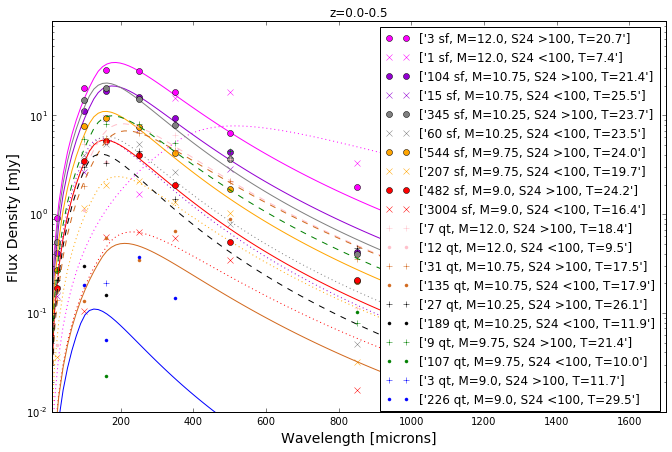

stacking scuba2_850
stacking spire_PSW
stacking pacs_green
stacking pacs_red
stacking spire_PMW
stacking spire_PLW
stacking mips24


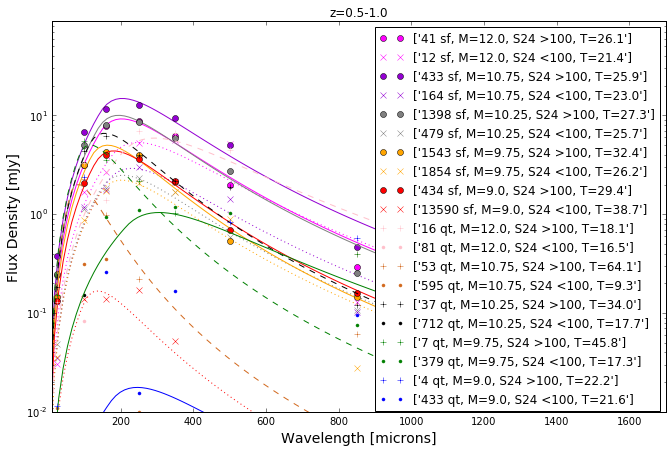

stacking scuba2_850
stacking spire_PSW
stacking pacs_green
stacking pacs_red
stacking spire_PMW
stacking spire_PLW
stacking mips24


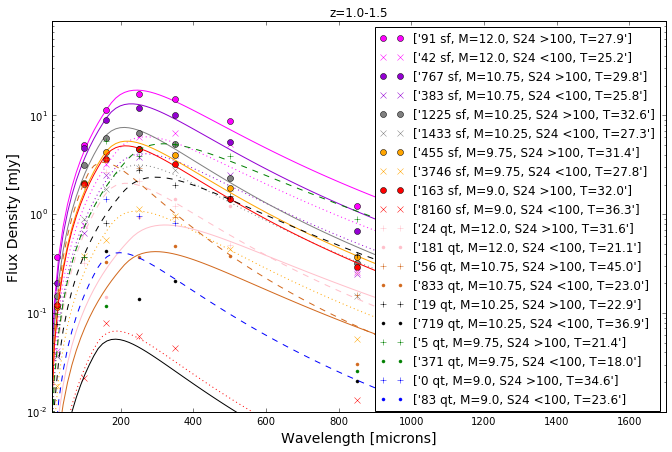

stacking scuba2_850
stacking spire_PSW
stacking pacs_green
stacking pacs_red
stacking spire_PMW
stacking spire_PLW
stacking mips24


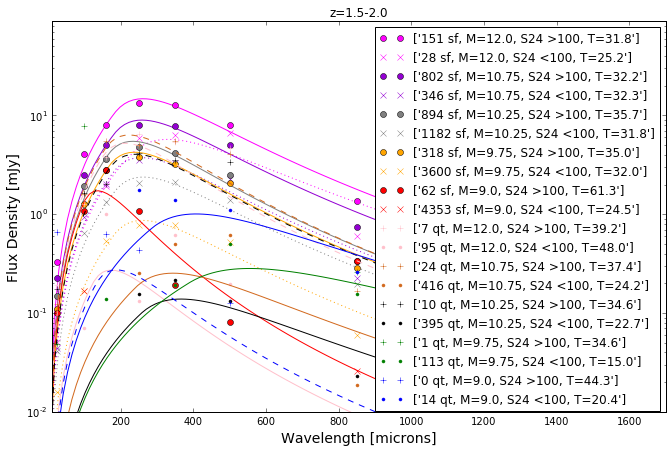

stacking scuba2_850
stacking spire_PSW
stacking pacs_green
stacking pacs_red
stacking spire_PMW
stacking spire_PLW
stacking mips24


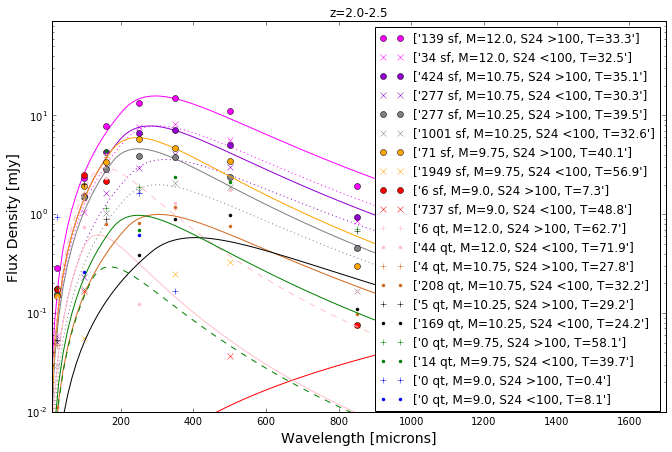

stacking scuba2_850
stacking spire_PSW
stacking pacs_green
stacking pacs_red
stacking spire_PMW
stacking spire_PLW
stacking mips24


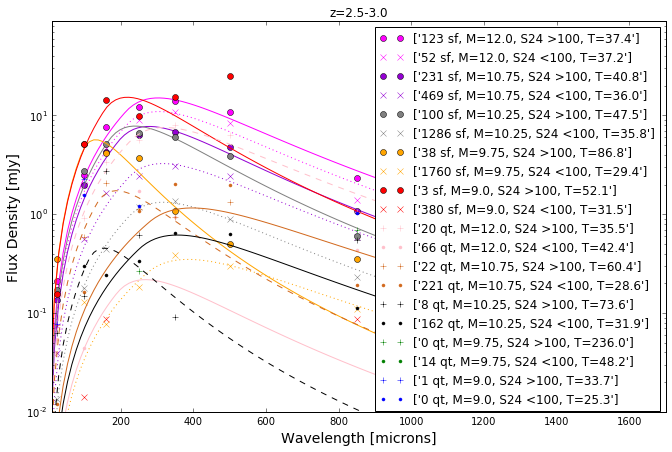

stacking scuba2_850
stacking spire_PSW
stacking pacs_green
stacking pacs_red
stacking spire_PMW
stacking spire_PLW
stacking mips24


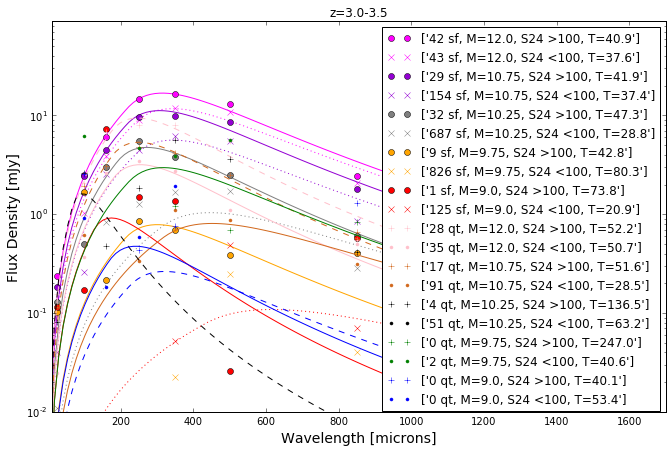

stacking scuba2_850
stacking spire_PSW
stacking pacs_green
stacking pacs_red
stacking spire_PMW
stacking spire_PLW
stacking mips24


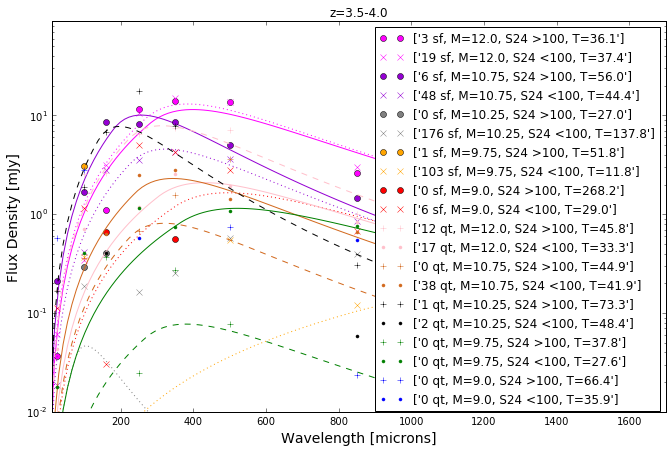

In [19]:
#Stack in redshift bins, with Layers divided by Stellar Mass and Star-Forming/Quiescent Galaxies
pop = ['qt','sf']
npop=2
#pop = ['sf']
#npop=1
all_stacked_fluxes = np.zeros([nwv,nz,nm,npop,2])
all_luminosity_temp= np.zeros([nz,nm,npop,2])
wvs = np.array(wavelength)[indstack]
wv_mod = np.linspace(5,1200,100)

mips24_cut = 100 #75

for iz in range(nz):
    zn = z_nodes[iz:iz+2]
    uVista.get_sf_qt_mass_redshift_bins(zn,m_nodes)
    for kg in range(npop):
        initpop = True
        if kg != 0: initpop = False
        uVista.get_criteria_specific_redshift_bins(zn,m_nodes,sfg=kg,criteria = 'f24',crange=[mips24_cut],initialize_pop= initpop)
    radec_m_z_p = uVista.subset_positions(uVista.id_crit)
    stacked_fluxes =  None
    n_sources_max = None
    #pdb.set_trace()
    stacked_fluxes  = stack_libraries_in_redshift_slices(
        sky_library_gaussians,
        radec_m_z_p)
    
    #pdb.set_trace()
    args = radec_m_z_p.keys()
    for iwv in range(nwv):
        stacked_fluxes_wv = stacked_fluxes[str(wavelength[indstack[0][iwv]])]
        for j in range(nm):
            for k in range(npop):
                #arg = 'z_'+str(zn[0])+'-'+str(zn[1])+'__m_'+str(m_nodes[j])+'-'+str(m_nodes[j+1])+'_'+pop[k]
                arg = 'z_'+str(round(zn[0],3))+'_'+str(round(zn[1],3))+'__m_'+str(round(m_nodes[j],3))+'_'+str(round(m_nodes[j+1],3))+'__f24'+'_ge_'+str(round(mips24_cut,2))+'_'+pop[k]
                all_stacked_fluxes[iwv,iz,j,k,1] = stacked_fluxes_wv[clean_args(arg)].value
                arg = 'z_'+str(round(zn[0],3))+'_'+str(round(zn[1],3))+'__m_'+str(round(m_nodes[j],3))+'_'+str(round(m_nodes[j+1],3))+'__f24'+'_lt_'+str(round(mips24_cut,2))+'_'+pop[k]
                all_stacked_fluxes[iwv,iz,j,k,0] = stacked_fluxes_wv[clean_args(arg)].value
    
    #pdb.set_trace()
    #PLOT
    plt.figure(figsize=[11,7])
    plt.ylim([-1e-1,3e0])
    plt.ylim([1e-2,9e1])
    plt.xlim([20,510])
    plt.xlim([10,1700])
    plt.yscale('log')
    plt.title('z='+str(zn[0])+'-'+str(zn[1]))
    plt.ylabel('Flux Density [mJy]',fontsize=14)
    plt.xlabel('Wavelength [microns]',fontsize=14)
    lnlo=['',':']
    ptlo=['.','x']
    lnhi=['--','']
    pthi=['+','o']
    for k in range(npop)[::-1]:
        for j in range(nm)[::-1]:
            arg = 'z_'+str(round(zn[0],3))+'_'+str(round(zn[1],3))+'__m_'+str(round(m_nodes[j],3))+'_'+str(round(m_nodes[j+1],3))+'__f24'+'_ge_'+str(round(mips24_cut,2))+'_'+pop[k]
            ng = len(radec_m_z_p[clean_args(arg)][0])
            flux_wv = (all_stacked_fluxes[:,iz,j,k,1] )   
            m = fast_sed_fitter(wvs,flux_wv,covar=np.sqrt(abs(flux_wv)))
            ymod = fast_sed(m,wv_mod)
            plt.plot(wv_mod,1e3*ymod[0],lnhi[k],color=popcolor[npop*j+k])
            plt.plot(wvs,1e3*flux_wv,pthi[k],color=popcolor[npop*j+k],label=[str(ng)+' '+pop[k]+', M='+str(round(np.mean(m_nodes[j:j+2]),2))+', S24 >'+str(mips24_cut)+', T='+str(round((1.0+z_mid[iz])*m['T_observed'].value,1))])
            
            arg = 'z_'+str(round(zn[0],3))+'_'+str(round(zn[1],3))+'__m_'+str(round(m_nodes[j],3))+'_'+str(round(m_nodes[j+1],3))+'__f24'+'_lt_'+str(round(mips24_cut,2))+'_'+pop[k]
            ng = len(radec_m_z_p[clean_args(arg)][0])
            flux_wv = (all_stacked_fluxes[:,iz,j,k,0] )   
            m = fast_sed_fitter(wvs,flux_wv,covar=np.sqrt(abs(flux_wv)))
            ymod = fast_sed(m,wv_mod)
            plt.plot(wv_mod,1e3*ymod[0],lnlo[k],color=popcolor[npop*j+k])
            plt.plot(wvs,1e3*flux_wv,ptlo[k],color=popcolor[npop*j+k],label=[str(ng)+' '+pop[k]+', M='+str(round(np.mean(m_nodes[j:j+2]),2))+', S24 <'+str(mips24_cut)+', T='+str(round((1.0+z_mid[iz])*m['T_observed'].value,1))])
                        
            plt.legend()
            
            #q = fast_double_sed_fitter(wvs,flux_wv,covar=np.sqrt(abs(flux_wv)))
            
    plt.show()
    #pdb.set_trace()

In [ ]:
k=1
for iwv in range(nwv):
    plt.figure()
    for j in range(nm):
        plt.yscale('log')
        plt.title(pop[k]+' fluxes: '+str(wavelength[indstack[0][iwv]]))
        plt.xlabel('Redshift',fontsize=14)
        plt.ylabel('Flux Density [mJy]',fontsize=14)
        plt.plot(z_mid,1e3*abs(all_stacked_fluxes[iwv,:,j,k]),'o')
        plt.plot(z_mid,1e3*abs(all_stacked_fluxes[iwv,:,j,k]))
    plt.show()

In [ ]:
k=1
for iwv in range(nwv):
    plt.figure()
    for i in range(nz):
        plt.yscale('log')
        plt.title(pop[k]+'fluxes: '+str(wavelength[indstack[0][iwv]]))
        plt.xlabel('Stellar Mass [M_star]',fontsize=14)
        plt.ylabel('Flux Density [mJy]',fontsize=14)
        plt.plot(m_mid,1e3*(all_stacked_fluxes[iwv,i,:,k]),'o')
        plt.plot(m_mid,1e3*(all_stacked_fluxes[iwv,i,:,k]))
    plt.show()

In [ ]:
UDS_stacked_fluxes = {}
UDS_stacked_fluxes['redshifts'] = z_nodes
UDS_stacked_fluxes['stellar_masses'] = m_nodes
UDS_stacked_fluxes['wavelengths'] = np.array(wavelength)[indstack]
UDS_stacked_fluxes['populations'] = pop
for iz in range(nz):
    zn = z_nodes[iz:iz+2]
    for j in range(nm)[::-1]:
        for k in range(npop):
            arg = 'S__z_'+str(zn[0])+'-'+str(zn[1])+'__m_'+str(m_nodes[j])+'-'+str(m_nodes[j+1])+'__'+pop[k]
            UDS_stacked_fluxes[arg] = all_stacked_fluxes[:,iz,j,k]

In [ ]:
print nz,nm,npop

In [ ]:
path_pickle = '/data/simstack/pickles/'
file_fluxes_pickle = 'UDS_fluxes__'+str(nz)+'_redshifts__'+str(nm)+'_masses__'+str(npop)+'_pops'+'.p'#'_w_aztec.p'
pickle.dump( UDS_stacked_fluxes, open( path_pickle+file_fluxes_pickle, "wb" ) )

In [ ]:
wvs = np.array(wavelength)[indstack]
luminosities = np.zeros([nz,nm])
temperatures_hot = np.zeros([nz,nm])
temperatures_cold = np.zeros([nz,nm])

luminosity_dictionary = {}
lumfit_dictionary = {}

for iz in range(nz):
    zn = z_nodes[iz:iz+2] 
    plt.ylim([9,14])
    for j in range(nm)[::-1]:
        flux_wv = (all_stacked_fluxes_psfs[:,iz,j,1] )   
        m = fast_double_sed_fitter(wvs,flux_wv,covar=np.sqrt(abs(flux_wv)))
        #sed = fast_sed(m, wvs)
        [L_mod_hot,L_mod_cold] = fast_double_Lir(m, np.mean(zn))
        L_mod = L_mod_hot.value + L_mod_cold.value
        luminosities[iz,j] = L_mod
        temperatures_hot[iz,j] = m['T_hot'].value * np.mean(zn)
        temperatures_cold[iz,j] = m['T_cold'].value * np.mean(zn)
        #print temperatures[iz,k] 
        
for j in range(nm)[::-1]:
    luminosity_dictionary['L_sed'+str(j)] = luminosities[:,j]
    luminosity_dictionary['T_sed_hot'+str(j)] = temperatures_hot[:,j]
    luminosity_dictionary['T_sed_cold'+str(j)] = temperatures_cold[:,j]
        #print LIR.value
        #plt.plot(np.mean(zn),np.log10(LIR.value),'o')
    plt.plot(z_mid,np.log10(luminosity_dictionary['L_sed'+str(j)]))
        #plt.yscale('log')
        
    plt.ylabel('Luminosity [L_star]',fontsize=14)
    plt.xlabel('Redshift',fontsize=14)
#plt.show()

In [ ]:
print L_mod_hot
print L_mod_cold
m

In [ ]:
wvs = np.array(wavelength)[indstack]
luminosities = np.zeros([nz,nm])
temperatures = np.zeros([nz,nm])
luminosity_dictionary = {}
lumfit_dictionary = {}

for iz in range(nz):
    zn = z_nodes[iz:iz+2] 
    plt.ylim([9,14])
    for j in range(nm)[::-1]:
        flux_wv = (all_stacked_fluxes_psfs[:,iz,j,1] )   
        m = fast_sed_fitter(wvs,flux_wv,covar=np.sqrt(abs(flux_wv)))
        #sed = fast_sed(m, wvs)
        L_mod = fast_Lir(m, np.mean(zn))
        luminosities[iz,j] = L_mod.value
        temperatures[iz,j] = m['T_observed'].value * np.mean(zn)
        #print temperatures[iz,k] 
        
for j in range(nm)[::-1]:
    luminosity_dictionary['L_sed'+str(j)] = luminosities[:,j]
    luminosity_dictionary['T_sed'+str(j)] = temperatures[:,j]
        #print LIR.value
        #plt.plot(np.mean(zn),np.log10(LIR.value),'o')
    plt.plot(z_mid,np.log10(luminosity_dictionary['L_sed'+str(j)]))
        #plt.yscale('log')
        
    plt.ylabel('Luminosity [L_star]',fontsize=14)
    plt.xlabel('Redshift',fontsize=14)
#plt.show()

In [ ]:
wvs = np.array(wavelength)[indstack]
luminosities = np.zeros([nz,nm])
temperatures = np.zeros([nz,nm])
luminosity_dictionary = {}
lumfit_dictionary = {}

for iz in range(nz):
    zn = z_nodes[iz:iz+2] 
    plt.ylim([9,14])
    for j in range(nm)[::-1]:
        flux_wv = (all_stacked_fluxes_psfs[:,iz,j,0] )   
        m = fast_double_sed_fitter(wvs,flux_wv,covar=np.sqrt(abs(flux_wv)))
        #sed = fast_sed(m, wvs)
        [L_mod_hot,L_mod_cold] = fast_double_Lir(m, np.mean(zn))
        L_mod = L_mod_hot.value + L_mod_cold.value
        luminosities[iz,j] = L_mod
        temperatures[iz,j] = m['T_hot'].value * np.mean(zn)
        #print temperatures[iz,k] 
        
for j in range(nm)[::-1]:
    luminosity_dictionary['L_sed'+str(j)] = luminosities[:,j]
    luminosity_dictionary['T_sed'+str(j)] = temperatures[:,j]
        #print LIR.value
        #plt.plot(np.mean(zn),np.log10(LIR.value),'o')
    plt.plot(z_mid,np.log10(luminosity_dictionary['L_sed'+str(j)]))
        #plt.yscale('log')
        
    plt.ylabel('Luminosity [L_star]',fontsize=14)
    plt.xlabel('Redshift',fontsize=14)
#plt.show()

In [ ]:
m = fast_double_sed_fitter(wvs,flux_wv,covar=np.sqrt(abs(flux_wv)))

In [ ]:
wvs = np.array(wavelength)[indstack]
luminosities = np.zeros([nz,nm])
temperatures = np.zeros([nz,nm])
luminosity_dictionary = {}
lumfit_dictionary = {}
plt.figure(figsize=[4,5])
for iz in range(nz):
    zn = z_nodes[iz:iz+2] 
    plt.ylim([0.2,3])
    plt.xlim([9.5,11.5])
    for j in range(nm)[::-1]:
        flux_wv = (all_stacked_fluxes_psfs[:,iz,j,1] )   
        m = fast_sed_fitter(wvs,flux_wv,covar=np.sqrt(abs(flux_wv)))
        #sed = fast_sed(m, wvs)
        L_mod = fast_Lir(m, np.mean(zn))
        luminosities[iz,j] = L_mod.value
        temperatures[iz,j] = m['T_observed'].value * np.mean(zn)
        #print temperatures[iz,k] 
        
for i in range(nz):
    luminosity_dictionary['L_sed'+str(i)] = luminosities[i,:]
    luminosity_dictionary['T_sed'+str(i)] = temperatures[i,:]
        #print LIR.value
        #plt.plot(np.mean(zn),np.log10(LIR.value),'o')
    plt.plot(m_mid,np.log10(conv_sfr*(luminosity_dictionary['L_sed'+str(i)])))#,label=z_mid[i])
        #plt.yscale('log')
        
    plt.ylabel('SFR [M_star/yr]',fontsize=14)
    plt.xlabel('Stellar Mass',fontsize=14)
    plt.legend()
#plt.show()

In [ ]:
tbl.keys()
#tbl.SFR_UV.values